In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
from huggingface_hub import hf_hub_download

repo_id = "Tracygu/dnscustom"
data_path = hf_hub_download(repo_id=repo_id, filename="DNS_CHALLENGE/processed_yz/test.pt", repo_type="dataset")

repo_id = "Tracygu/AudioCodec"
config_path = hf_hub_download(repo_id=repo_id, filename="swin-18k-scale-baseline/config.json", repo_type="model")
weight_path = hf_hub_download(repo_id=repo_id, filename="swin-18k-scale-baseline/best.pt", repo_type="model")

In [7]:
import torch, json
from tqdm.notebook import tqdm
from models.codec import SwinCrossScaleCodec

config = json.load(open(config_path, "r"))
config["fuse_net"] = None
weight = torch.load(weight_path, map_location=device)

model = SwinCrossScaleCodec(**config)
model.load_state_dict(weight["model_state_dict"])

model.to(device)

data = torch.load(data_path, map_location=device)
data.shape

Codec Causality: False
Apply Vanilla Residual Fusion Net for Swin Codec
Quantization Vis: 
     Freq dims:  [2, 2, 4, 8, 16, 32]
     Channel(hidden) dims:  [384, 384, 192, 96, 72, 45]
     projections from:  [768, 768, 768, 768, 1152, 1440]
     projections to:  [192, 192, 384, 384, 576, 720]
     group_vq_dims:  [384, 384, 768, 768, 1152, 1440]


<All keys matched successfully>

In [67]:
def calculate_codebook_utility(code, codebook_size=1024):
    flat_indices = code.flatten()
    total_indices = flat_indices.shape[0]
    index_counts = torch.bincount(flat_indices, minlength=codebook_size)

    index_probabilities = index_counts.float() / total_indices
    entropy = -(index_probabilities * torch.log(index_probabilities + 1e-10)).sum()
    used_entries = torch.sum(index_counts > 0).item()
    percentage_used = used_entries / codebook_size * 100
    print(f'Entropy: {entropy.item():.2f}', end="  ")
    print(f'Percentage of VQ entries used: {used_entries}/{codebook_size} = {percentage_used:.2f}%')
    return entropy.item(), percentage_used

def gather_all_code(model, data, num_streams=6):

    all_codes = {f"stream {i}":[] for i in range(num_streams)}
    for i in tqdm(range(data.size(0)), desc="Gathering codes"):
        x = data[i:i+1]
        multi_codes, _ = model.encode(x, num_streams=num_streams)

        for j in range(num_streams):
            jth_code = multi_codes[j] # [group_size, points]
            all_codes[f"stream {j}"].append(jth_code)
    for key, val in all_codes.items():
        all_codes[key] = torch.cat(val, dim=1) # [group_size, points*num_data]
    
    return all_codes

def run(model, data, num_streams):

    data = data[:, :-80]

    all_codes = gather_all_code(model, data, num_streams)
    group_size = all_codes["stream 0"].size(0)

    print("Counting")
    all_stats = []
    for j in range(num_streams):
        stream_i_stats = []
        for g in range(group_size): 
            code = all_codes[f"stream {j}"][g:g+1]
            print(f"Evaluate {j+1}-th/{num_streams} stream and {g+1}-th/{group_size} codebook: ")
            entropy, percentage_used = calculate_codebook_utility(code, codebook_size=1024)
            stream_i_stats.append((entropy, percentage_used))
        all_stats.append(stream_i_stats)

    return all_stats

In [ ]:
all_stats = run(model, data, num_streams=6)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(all_stats, title="VQ Utility Table on Testset"):

    fig, ax1 = plt.subplots(figsize=(16, 10))
    fig.suptitle(title, fontsize=12)

    ax1.set_xlabel('Percentage Used')
    ax1.set_xlim(0, 120)
    ax2 = ax1.twiny()
    ax2.set_xlim(0, 40)
    ax2.set_xlabel('Entropy')

    bar_width = 0.4

    num_vq = len(all_stats[0])
    num_stream = len(all_stats)

    gap_between_vqs = 0.3
    gap_between_streams = 1

    total_bar_height = num_vq * bar_width + (num_vq - 1) * gap_between_vqs
    total_height = num_stream * total_bar_height + (num_stream - 1) * gap_between_streams

    y_positions = np.arange(0, total_height, total_bar_height+gap_between_streams)
    for i, stream_stats in enumerate(all_stats):
        entropies, percentages = zip(*stream_stats)

        y = y_positions[i] + np.arange(num_vq) * (bar_width + gap_between_vqs)
        ax1.barh(y, percentages, height=bar_width, color='green', edgecolor='white')

        percentage_aligned = [p/3 for p in percentages]
        ax2.barh(y, entropies, left=percentage_aligned, height=bar_width, color='blue', edgecolor='white')

    ax1.set_xlabel('Percentage Used -/1024 (%)')
    ax1.set_ylabel("VQ Stream")
    ax1.set_yticks(y_positions + (total_bar_height - bar_width) / 2)
    ax1.set_yticklabels([f'Stream {i+1}' for i in range(len(all_stats))])

    ax1.grid(axis="x")
    ax1.legend(['Percentage Used'], loc='upper right')
    ax2.legend(['Entropy'], loc='upper left')

    plt.tight_layout()
    plt.show()

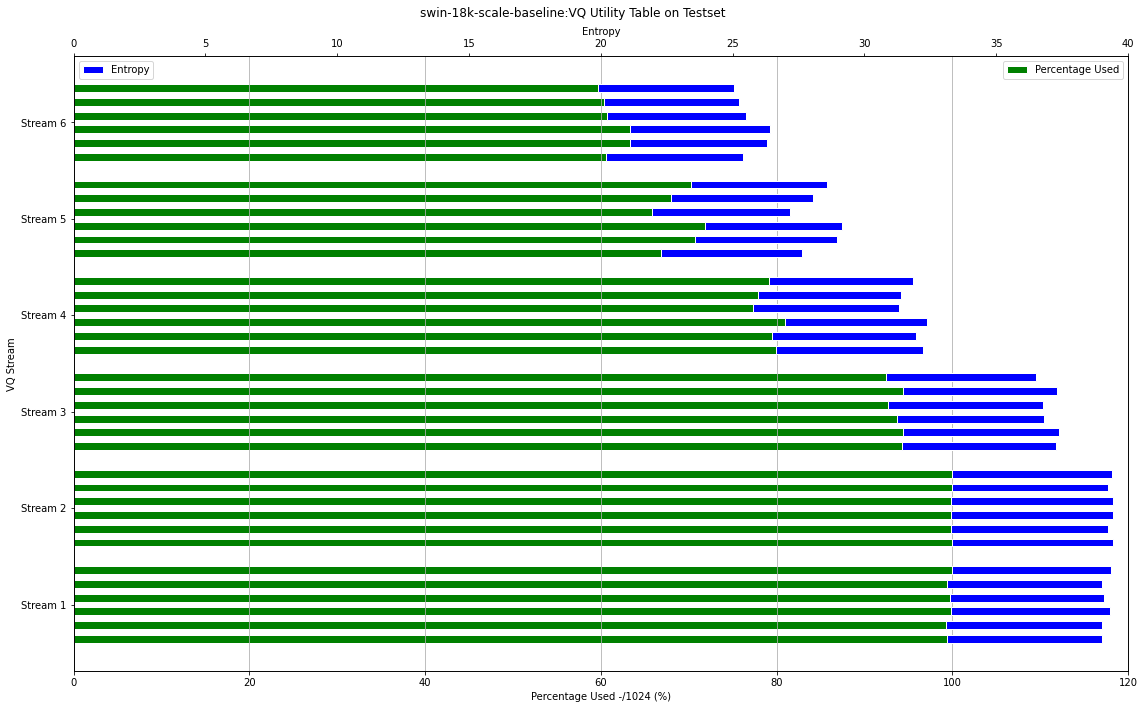

In [17]:
import json

all_stats_saved = json.load(open("/Users/tracy/Desktop/swin-18k-scale-baseline/test_vq_stats.json"))
model_name, test_all_stats = all_stats_saved["model_name"], all_stats_saved["stats"]

visualize(test_all_stats, title=f"{model_name}:VQ Utility Table on Testset")

In [ ]:
visualize(all_stats["train"])
visualize(all_stats["test"])